In [4]:
using Gen
using Plots
using Logging
using StatsBase
Logging.disable_logging(Logging.Info)

LogLevel(1)

# Tracking Fireflies


## Tracking by Detection
In computer vision, one of the most popular methods for tracking objects is called "Tracking-by-Detection". In a first pass, you use an object detector to identify all the objects of interest in a scene. Next, you apply some dynamics update to your detected objects (typically some kind of linear filter, like a Kalman Filter). 

This tracking-by-detection method can be brittle when there's lots of occlusion, and you don't have reliable detection. 

## What happens when there's not much detection?

Let's imagine it's a summer evening. You're sitting on a porch, and see a small glow in the distance. It's a firefly! If you want to catch the firefly, you'll observe a blink, make some movements, and wait for another blink. We don't just get rid of a track if we don't detect anything. Fireflies are an excellent use case for investigating how humans track under uncertainty. When do we give up on a track? When do we wait for more information? 

## Probabilistic Generative Model

Cognitive Science has a rich tradition of studying human behavior with probabilistic generative models. Here, we'll see if we can capture human behavior with a generative model of mock firefly behavior.

In [3]:
# Define firefly observation model
@gen function single_firefly(scene_size::Int, steps::Int)
    # sample number of fireflies
    xs = zeros(steps)
    ys = zeros(steps)
    vxs = zeros(steps)
    vys = zeros(steps) 
    blinking = zeros(steps)

    # We'll assign the firefly a blinking frequency
    blink_freq = {:freq} ~ normal(0.25, 0.05)

    for t in 1:steps
        if t == 1
            # We'll initialize the position uniformly in our grid
            xs[t] = {(:x, t)} ~ uniform_discrete(1, scene_size - 1)
            ys[t] = {(:y, t)} ~ uniform_discrete(1, scene_size - 1)

            # We can assign a uniform discrete velocity to the firefly as well
            vxs[t] = {(:vx, t)} ~ uniform_discrete(-1, 1)
            vys[t] = {(:vy, t)} ~ uniform_discrete(-1, 1)
        else
            prev_x = xs[t - 1]
            prev_y = ys[t - 1]

            vx = vxs[t - 1]
            vy = vys[t - 1]

            # Keep the firefly in the scene bounds
            if prev_x + vx < 0 || prev_x + vx > scene_size 
                vx = -vx
            end
            if prev_y + vy < 0 || prev_y + vy > scene_size 
                vy = -vy
            end
            
            xs[t] = {(:x, t)} ~ normal(prev_x + vx, 0.05)
            ys[t] = {(:y, t)} ~ normal(prev_y + vy, 0.05)
            vxs[t] = {(:vx, t)} ~ uniform_discrete(-1, 1)
            vys[t] = {(:vy, t)} ~ uniform_discrete(-1, 1)
        end

        blinking[t] = {(:blinking, t)} ~ bernoulli(blink_freq)
    end
    
    return Dict("xs" => xs, "ys" => ys, "blink_freq" => blink_freq, "blinking" => blinking)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##single_firefly#312", Bool[0, 0], false)

In [4]:
function visualize_trace(tr)
    plot()
    scene_size, steps = get_args(tr)
    retval = get_retval(tr)
    xs = retval["xs"]
    ys = retval["ys"]
    choices = get_choices(tr)
    blink_freq = 0.25 #choices[:freq]

    anim = Plots.@animate for i in 1:steps
        fig = plot(layout = grid(1,2), legend=false, size=(800, 400))
        if i > 1
            plot!(fig[1], xs[1:i], ys[1:i], color=colormap("Blues", i), markersize=2, label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size), title="Actual Location (T=$i)")
        end
        
        blinking = Int(choices[(:blinking, i)])
        if blinking == 1
            scatter!(fig[2], [xs[i]], [ys[i]], color="yellow", markersize=10, label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size), title="Observed Location (T=$i)") 
            scatter!(fig[1], [xs[i]], [ys[i]], color="yellow", markersize=10, label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size)) 
        else
            scatter!(fig[2], [], [], label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size), title="Observed Location (T=$i)")
            scatter!(fig[1], [xs[i]], [ys[i]], markercolor=RGBA(1, 1, 1, 0), markersize=10, label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size)) 
        end

        xlims!(0, scene_size)
        ylims!(0, scene_size)
    end
    return anim
end


visualize_trace (generic function with 1 method)

Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/tmp.gif")
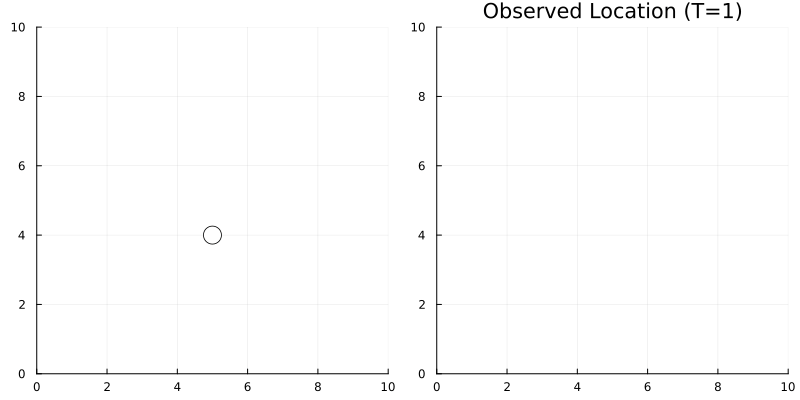

In [5]:
scene_size = 10
steps = 50
actual_trace = simulate(single_firefly, (scene_size, steps))
gif(visualize_trace(actual_trace), fps=5)


In [6]:
function make_constraints(trace)
    constraints = choicemap()
    choices = get_choices(trace)
    scene_size, t = get_args(trace)

    for i in 1:t
        x = choices[(:x, i)]
        y = choices[(:y, i)]
        blinking = choices[(:blinking, i)]
        if Int(blinking) == 1 
            constraints[(:x, i)] = x
            constraints[(:y, i)] = y
            constraints[(:blinking, i)] = blinking
        else
            constraints[(:blinking, i)] = 0
        end
    end
    return constraints
end

make_constraints (generic function with 1 method)

In [7]:
constraints = make_constraints(actual_trace)

│
├── (:blinking, 4) : true
│
├── (:blinking, 10) : 0
│
├── (:blinking, 36) : 0
│
├── (:blinking, 1) : 0
│
├── (:blinking, 27) : 0
│
├── (:blinking, 12) : 0
│
├── (:blinking, 33) : true
│
├── (:blinking, 2) : 0
│
├── (:blinking, 44) : 0
│
├── (:blinking, 37) : true
│
├── (:blinking, 7) : 0
│
├── (:blinking, 30) : 0
│
├── (:y, 21) : 0.8729187314146624
│
├── (:x, 38) : 3.6827987287609494
│
├── (:blinking, 16) : 0
│
├── (:blinking, 22) : 0
│
├── (:blinking, 21) : true
│
├── (:blinking, 31) : 0
│
├── (:blinking, 39) : 0
│
├── (:blinking, 45) : 0
│
├── (:x, 4) : 5.902314289515333
│
├── (:blinking, 5) : 0
│
├── (:blinking, 8) : 0
│
├── (:x, 21) : 8.780562828934608
│
├── (:blinking, 35) : 0
│
├── (:x, 40) : 2.6534272602919757
│
├── (:blinking, 24) : true
│
├── (:blinking, 20) : 0
│
├── (:blinking, 25) : 0
│
├── (:y, 40) : 3.1456367994091545
│
├── (:blinking, 17) : 0
│
├── (:blinking, 46) : 0
│
├── (:blinking, 43) : 0
│
├── (:x, 37) : 4.713325129531478
│
├── (:blinking, 40) : true
│
├── (:blin

In [8]:
tr, w = generate(single_firefly, (scene_size, steps), constraints)
println(w)

-16045.891149823825


In [9]:
compute_steps = 10000
(trace, w) = Gen.importance_resampling(single_firefly, (scene_size, steps,), constraints, compute_steps);

In [10]:
w

-1830.5438861474051

Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/tmp.gif")
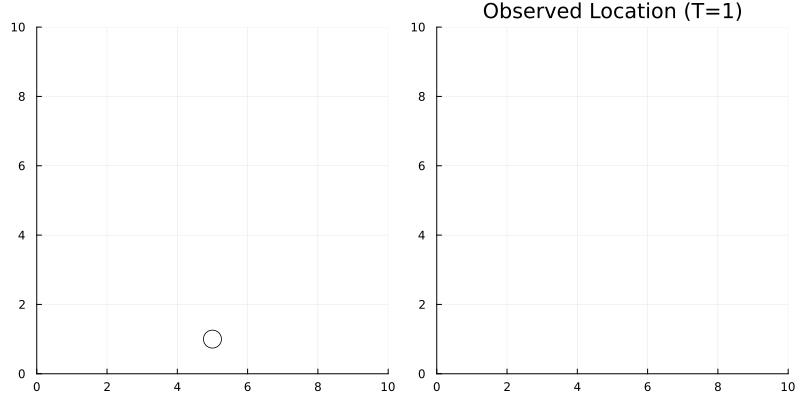

In [11]:
gif(visualize_trace(trace), fps=5)

In [12]:
function get_observation(constraints::ChoiceMap, t::Int)
    obs = choicemap()

    if Gen.has_value(constraints, (:x, t))
        obs[(:x, t)] = constraints[(:x, t)]
        obs[(:y, t)] = constraints[(:y, t)]
        obs[(:blinking, t)] = constraints[(:blinking, t)]
    else
        obs[(:blinking, t)] = 0
    end
    return obs
end

function particle_filter_no_resampling(num_steps::Int, scene_size::Int, num_particles::Int, constraints::ChoiceMap, num_samples::Int)
    
    init_obs = get_observation(constraints, 1)
    state = Gen.initialize_particle_filter(single_firefly, (num_steps, scene_size,), init_obs, num_particles)

    # steps
    for t=2:num_steps
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = get_observation(constraints, t)
        Gen.particle_filter_step!(state, (num_steps, scene_size,), (UnknownChange(),), obs)
    end

    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;


## Exact Inference

Let's try to get a version of this working as exact inference. First, we'll need to discretize everything, so let's construct a slightly simpler version of the generative model:

In [13]:
# Define firefly observation model
@gen function simple_discrete_firefly(scene_size::Int, steps::Int)
    # sample number of fireflies
    xs = zeros(Int, steps)
    ys = zeros(Int, steps)
    vxs = zeros(Int, steps)
    vys = zeros(Int, steps)
    blinking = zeros(Int, steps)

    # Fix a blinking frequency
    blink_freq = 0.25

    for t in 1:steps
        # Update motion
        if t == 1
            # We'll initialize the position uniformly in our grid
            xs[t] = {(:x, t)} ~ uniform_discrete(0, scene_size)
            ys[t] = {(:y, t)} ~ uniform_discrete(0, scene_size)

        else
            prev_x = xs[t - 1]
            prev_y = ys[t - 1]
            
            xs[t] = {(:x, t)} ~ uniform_discrete(max(0, prev_x - 1), min(scene_size, prev_x + 1))
            ys[t] = {(:y, t)} ~ uniform_discrete(max(0, prev_y - 1), min(scene_size, prev_y + 1))
        end

        # Update blinking
        blinking[t] = {(:blinking, t)} ~ bernoulli(blink_freq)
    end
    
    return Dict("xs" => xs, "ys" => ys, "blink_freq" => blink_freq, "blinking" => blinking)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##simple_discrete_firefly#517", Bool[0, 0], false)

In [14]:
function get_observations(trace::Trace, steps::Int)
    obs = choicemap()
    choices = get_choices(trace)
    for i in 1:steps
        blinking = choices[(:blinking, i)]
        obs[(:blinking, i)] = blinking
        if blinking == true
            obs[(:x, i)] = choices[(:x, i)]
            obs[(:y, i)] = choices[(:y, i)]
        end
    end
    return obs
end

get_observations (generic function with 1 method)

Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/tmp.gif")
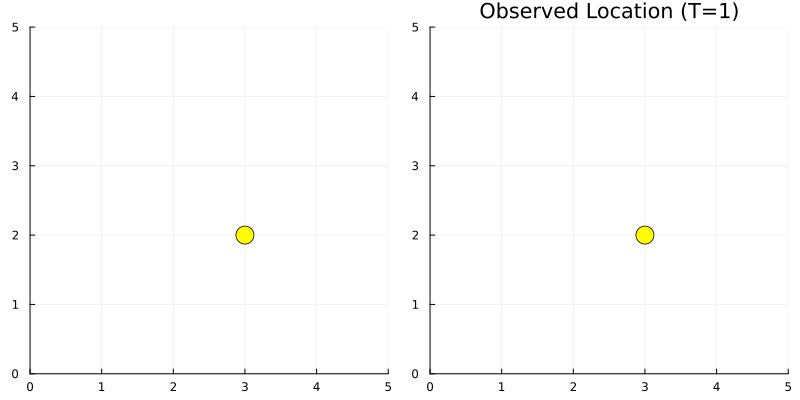

In [15]:
scene_size = 5
steps = 10
actual_trace = simulate(simple_discrete_firefly, (scene_size, steps))
gif(visualize_trace(actual_trace), fps=5)

Now let's write a loop to go through every possible state

In [16]:
observations = get_observations(actual_trace, steps)

│
├── (:x, 7) : 0
│
├── (:blinking, 4) : true
│
├── (:blinking, 10) : false
│
├── (:x, 9) : 1
│
├── (:blinking, 1) : true
│
├── (:blinking, 7) : true
│
├── (:y, 1) : 2
│
├── (:blinking, 9) : true
│
├── (:x, 4) : 1
│
├── (:blinking, 5) : true
│
├── (:blinking, 8) : false
│
├── (:x, 5) : 0
│
├── (:y, 7) : 0
│
├── (:y, 5) : 2
│
├── (:blinking, 6) : false
│
├── (:blinking, 2) : false
│
├── (:x, 1) : 3
│
├── (:y, 4) : 3
│
├── (:blinking, 3) : false
│
└── (:y, 9) : 0


In [17]:

function pos_in_bounds(pos, scene_size)
    if pos >= 0 && pos <= scene_size
        return true
    else 
        return false
    end
end

function enumerate_next_steps(x, y, scene_size)
    # breadth first search over all possible traces over a 10 step scene
    new_positions = []
    for vx in -1 : 1
        for vy in -1 : 1
            new_x = x + vx
            new_y = y + vy
            if pos_in_bounds(new_x, scene_size) && pos_in_bounds(new_y, scene_size)
                push!(new_positions, (new_x, new_y))
            end
        end
    end
    return new_positions
end

function exact_inference(observations, scene_size, steps)
    traces_by_time = [[] for _ in 1:steps]

    # Initialize trace to observation, otherwise enumerate possible starting positions
    if observations[(:blinking, 1)] == true
        init_trace = traces_by_time[1]
        chm = choicemap()
        chm[(:x, 1)] = observations[(:x, 1)]
        chm[(:y, 1)] = observations[(:y, 1)]
        chm[(:blinking, 1)] = true
        trace, _ = generate(simple_discrete_firefly, (scene_size, 1), chm)
        push!(init_trace, trace)
    else
        for start_x in 1:scene_size
            for start_y in 1:scene_size
                for blinking in [true, false]
                    init_traces = traces_by_time[1]
                    chm = choicemap()
                    chm[(:x, 1)] = start_x
                    chm[(:y, 1)] = start_y
                    chm[(:blinking, 1)] = false
                    trace, _ = generate(simple_discrete_firefly, (scene_size, 1), chm)
                    push!(init_traces, trace)
                end
            end
        end
    end

    # Constrain observation or enumerate possible next steps
    for t in 2:steps
        prev_traces = traces_by_time[t - 1]
        current_traces = traces_by_time[t]
        for prev_trace in prev_traces
            x = prev_trace[(:x, t - 1)]
            y = prev_trace[(:y, t - 1)]
            if observations[(:blinking, t)] == true
                chm = choicemap()
                chm[(:x, t)] = observations[(:x, t)]
                chm[(:y, t)] = observations[(:y, t)]
                chm[(:blinking, t)] = true
                new_trace, _ = update(prev_trace, (scene_size, t), (Gen.NoChange(), Gen.UnknownChange()), chm)
                if get_score(new_trace) > -Inf
                    push!(current_traces, new_trace)
                end
            else
                next_possible_steps = enumerate_next_steps(x, y, scene_size)
                for (new_x, new_y) in next_possible_steps
                    new_constraints = choicemap()
                    new_constraints[(:x, t)] = new_x
                    new_constraints[(:y, t)] = new_y
                    new_constraints[(:blinking, t)] = false
                    new_trace, _ = update(prev_trace, (scene_size, t), (Gen.NoChange(), Gen.UnknownChange()), new_constraints)
                    if get_score(new_trace) > -Inf
                        push!(current_traces, new_trace)
                    end
                end
            end
        end
    end

    return traces_by_time
end;

trace_ts = exact_inference(observations, 5, steps)


10-element Vector{Vector{Any}}:
 [Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##simple_discrete_firefly#517", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:x, 1) => Gen.ChoiceOrCallRecord{Int64}(3, -1.791759469228055, NaN, true), (:blinking, 1) => Gen.ChoiceOrCallRecord{Bool}(true, -1.3862943611198906, NaN, true), (:y, 1) => Gen.ChoiceOrCallRecord{Int64}(2, -1.791759469228055, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -4.969813299576001, 0.0, (5, 1), Dict{String, Any}("blink_freq" => 0.25, "blinking" => [1], "xs" => [3], "ys" => [2]))]
 [Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##simple_discrete_firefly#517", Bool[0, 0], false), Tri

In [18]:
for traces in trace_ts
    println(length(traces))
    loop_end = min(steps, length(traces))
    for i in 1:loop_end
        print(get_score(traces[i]))
        print(" ")
    end
end

1
-4.969813299576001 9
-7.4547199493640015 -7.4547199493640015 -7.4547199493640015 -7.4547199493640015 -7.4547199493640015 -7.4547199493640015 -7.4547199493640015 -7.4547199493640015 -7.4547199493640015 81
-9.939626599152001 -9.939626599152001 -9.939626599152001 -9.939626599152001 -9.939626599152001 -9.939626599152001 -9.939626599152001 -9.939626599152001 -9.939626599152001 -9.939626599152001 18
-13.52314553760811 -13.52314553760811 -13.52314553760811 -13.52314553760811 -13.52314553760811 -13.52314553760811 -13.52314553760811 -13.52314553760811 -13.52314553760811 -13.52314553760811 18
-17.106664476064218 -17.106664476064218 -17.106664476064218 -17.106664476064218 -17.106664476064218 -17.106664476064218 -17.106664476064218 -17.106664476064218 -17.106664476064218 -17.106664476064218 108
-19.186106017744052 -19.186106017744052 -19.186106017744052 -19.186106017744052 -19.186106017744052 -19.186106017744052 -19.186106017744052 -19.186106017744052 -19.186106017744052 -19.186106017744052 36
-

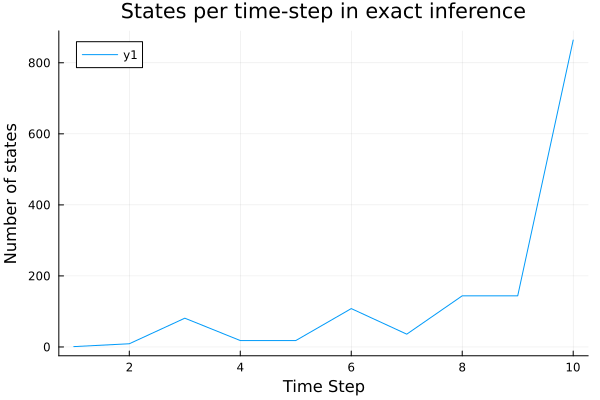

In [19]:
lengths = [length(traces) for traces in trace_ts]
plot(lengths)
xlabel!("Time Step")
ylabel!("Number of states")
title!("States per time-step in exact inference")

In [20]:
function exact_inference_visualization(traces_by_time, actual_trace, steps, scene_size=5)
    # At each step, for each trace plot location and lines for each possible location
    actual_xs = get_retval(actual_trace)["xs"]
    actual_ys = get_retval(actual_trace)["ys"]
    
    anim = Plots.@animate for t in 1:steps
        fig = plot(layout = grid(1,2), legend=false, size=(800, 400))
        i = 0

        num_traces = length(traces_by_time[t])

        traces_t = sample(traces_by_time[t], min(1000, num_traces), replace=false)
        for trace in traces_t

            i += 1
            if i > 500
                break
            end

            choices = get_choices(trace)
            x = choices[(:x, t)]
            y = choices[(:y, t)]
            if i > 1
                xs = [choices[(:x, _t)] for _t in 1:t]
                ys = [choices[(:y, _t)] for _t in 1:t]
                plot!(fig[2], xs, ys, alpha=0.1, label=nothing)
                plot!(fig[1], actual_xs[1:t], actual_ys[1:t], color="blue", markersize=2, label=nothing,)
            end

            scatter!(fig[1], [actual_xs[t]], [actual_ys[t]], color="blue", 
            xlim=(-1, scene_size + 1), ylim=(-1, scene_size + 1), markersize=10, label=nothing, title="Actual Location (T=$t)")
            
            blinking = choices[(:blinking, t)]

            if blinking == true
                scatter!(fig[2], [x], [y], color="yellow", markersize=10, label=nothing, 
                xlim=(-1, scene_size + 1), ylim=(-1, scene_size + 1), title="Observed Location (T=$t)") 
            else
                # plot Cross where firefly could be
                scatter!(fig[2], [x], [y], markersize=10, label=nothing, 
                xlim=(-1, scene_size + 1), ylim=(-1, scene_size + 1), title="Inferred Location (T=$t)", 
                alpha=0.1, mode="markers", marker_symbol="x")
            end
        end
    end
end

anim = exact_inference_visualization(trace_ts, actual_trace, steps)

Animation("/var/folders/vz/qv2p5zmj48g74_wv3kzkjlmc0000gn/T/jl_ENNNyl", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"])

Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/exact_inference.gif")
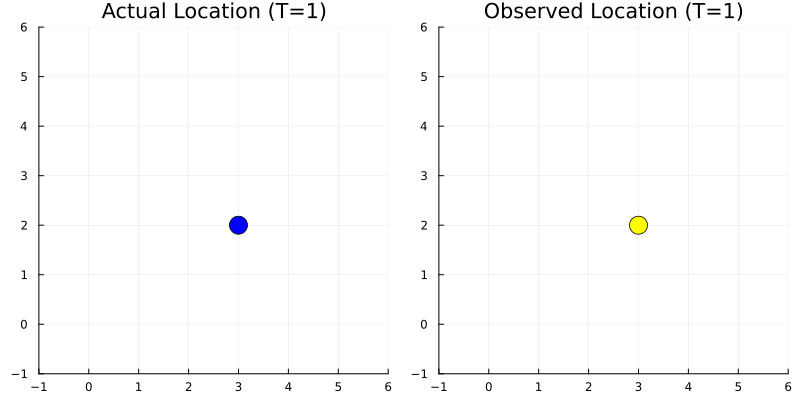

In [21]:
gif(anim, "exact_inference.gif", fps=1)

In [22]:
traces = [first(Gen.importance_resampling(simple_discrete_firefly, (scene_size, 40), observations, 2000)) for i in 1:9]

9-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##simple_discrete_firefly#517", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:x, 31) => Gen.ChoiceOrCallRecord{Int64}(0, -0.6931471805599453, NaN, true), (:blinking, 4) => Gen.ChoiceOrCallRecord{Bool}(true, -1.3862943611198906, NaN, true), (:y, 14) => Gen.ChoiceOrCallRecord{Int64}(3, -1.0986122886681098, NaN, true), (:blinking, 10) => Gen.ChoiceOrCallRecord{Bool}(false, -0.2876820724517809, NaN, true), (:y, 3) => Gen.ChoiceOrCallRecord{Int64}(2, -1.0986122886681098, NaN, true), (:y, 29) => Gen.ChoiceOrCallRecord{Int64}(0, -1.0986122886681098, NaN, true), (:blinking, 36) => Gen.ChoiceOrCallRecord{Bool}(false, -0.2876820724517809, NaN, true), (:blinking, 1) => Gen.ChoiceOrCallRecord{Bool}(true, -1

In [23]:
function stack_visualizations(traces, actual_trace, steps, scene_size)
    # At each step, for each trace plot location and lines for each possible location
    actual_xs = get_retval(actual_trace)["xs"]
    actual_ys = get_retval(actual_trace)["ys"]
    
    anim = Plots.@animate for t in 1:steps
        fig = plot(layout = grid(1,1), legend=false, size=(400, 400))
        i = 0

        num_traces = length(traces)
        for trace in traces
            i += 1
            choices = get_choices(trace)
            x = choices[(:x, t)]
            y = choices[(:y, t)]

            scatter!(fig[1], [actual_xs[t]], [actual_ys[t]], 
            ma=0.1, mscolor="blue", msalpha=0.1, mswidth=1, msstyle=:dash,
            xlim=(-1, scene_size + 1), ylim=(-1, scene_size + 1), markersize=10, 
            label=(i==1) ? "Actual Location" : nothing, title="Actual Location (T=$t)")
            
            xs = [choices[(:x, _t)] for _t in 1:t]
            ys = [choices[(:y, _t)] for _t in 1:t]
            alpha_score = abs(get_score(trace)) / 100
            plot!(fig[1], xs, ys, alpha=alpha_score, label=nothing, legend=true)
            plot!(fig[1], actual_xs[1:t], actual_ys[1:t], color="blue", markersize=2, label=nothing,)
            
            blinking = choices[(:blinking, t)]

            if blinking == true
                scatter!(fig[1], [x], [y], color="yellow", markersize=10, label=nothing, 
                xlim=(-1, scene_size + 1), ylim=(-1, scene_size + 1), title="Observed Location (T=$t)") 
            end
            # plot Cross where firefly could be
            scatter!(fig[1], [x], [y], markersize=10,
            xlim=(-1, scene_size + 1), ylim=(-1, scene_size + 1), title="Inferred Location (T=$t)", 
            alpha=alpha_score, mode="markers", markershape=:star, label=(i==1) ? "Predicted Location" : nothing,)
        
        end
    end
end

anim = stack_visualizations(traces, actual_trace, steps, scene_size)

Animation("/var/folders/vz/qv2p5zmj48g74_wv3kzkjlmc0000gn/T/jl_8O8d9A", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"])

Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/importance_resampling.gif")
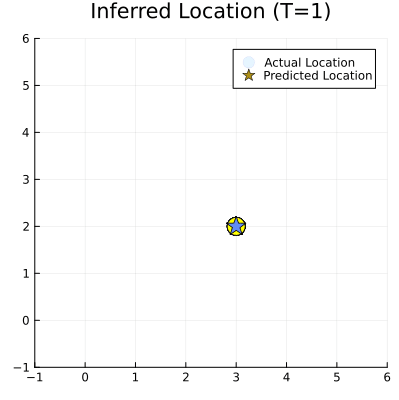

In [24]:
gif(anim, "importance_resampling.gif", fps=1)


Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/tmp.gif")
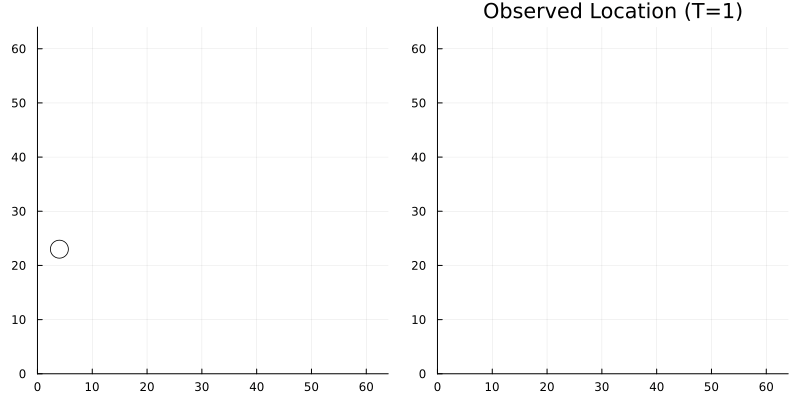

In [25]:
scene_size = 64
steps = 40
actual_trace = simulate(simple_discrete_firefly, (scene_size, steps))
observations = get_observations(actual_trace, steps)
gif(visualize_trace(actual_trace), fps=10)


Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/importance_resampling_large.gif")
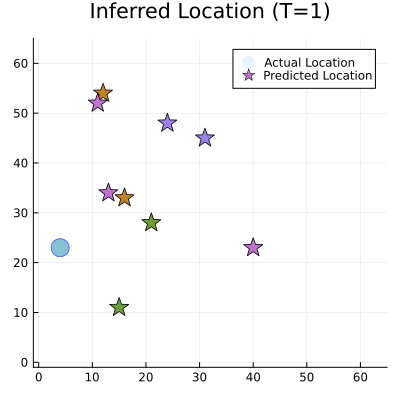

In [26]:
traces = [first(Gen.importance_resampling(simple_discrete_firefly, (scene_size, 40), observations, 2000)) for i in 1:9]
anim = stack_visualizations(traces, actual_trace, steps, scene_size)
gif(anim, "importance_resampling_large.gif", fps=1)

In [27]:
print([get_score(trace) for trace in traces])

[-Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf]

In [12]:
using Plots
using Distributions


volume(rand(RGBAf0, 3, 3, 3); algorithm = :absorptionrgba)

LoadError: UndefVarError: RGBAf0 not defined

In [64]:
mu_ = [0., 0.]
cov_ = [1. 0.; 0. 1.]
a = mvnormal(mu_, cov_)

2-element Vector{Float64}:
 -0.44675568108073244
  1.2148594813909248

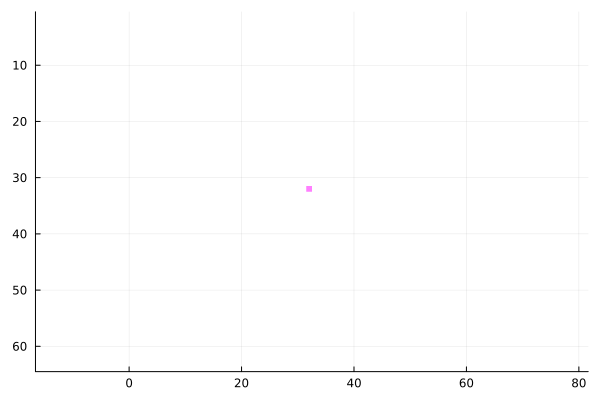

In [61]:
using Plots

H = 64
W = 64

function compute_alpha_glow(mu, sigma, H, W, xmax, ymax)
    min_x = mu - 2 * sigma_x
    min_y = mu - 2 * sigma_y

    max_x = mu + 2 * sigma_x
    max_y = mu + 2 * sigma_y

    xmin = max(min_x, 0)
    ymin = max(min_y, 0)
    xmax = min(max_x, W)
    ymax = min(max_y, H)

    x = range(xmin, xmax, length=10)
    y = range(ymin, ymax, length=10)
    
    alpha = normal(x, mu, sigma) * normal(y, mu, sigma)'
    return alpha
end

vals = zeros(Float64, 4, H, W)
vals[:, 32, 32] .= [1.0, 0.0, 1.0, .5]
matrix = clamp.(vals, 0.0, 1.0)
img = colorview(RGBA, matrix);
plot(img)